## 1️⃣ Import Thư Viện Cần Thiết

In [32]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Thiết lập font cho Vietnamese
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("✓ Thư viện được import thành công")

✓ Thư viện được import thành công


## 2️⃣ Tải và Chuẩn Bị Dữ Liệu Mạng

In [33]:
# Tải dữ liệu
print("[+] Đang tải dữ liệu...")

# Tải nodes
with open('graph_out/nodes_unified.csv', 'r', encoding='utf-8') as f:
    nodes_df = pd.read_csv(f)

# Tải edges
with open('graph_out/edges_unified.csv', 'r', encoding='utf-8') as f:
    edges_df = pd.read_csv(f)

print(f"✓ Đã tải {len(nodes_df)} nodes và {len(edges_df)} edges")

# Thống kê nodes theo loại
print("\n[NODES THEO LOẠI]")
node_types = nodes_df['type'].value_counts()
for node_type, count in node_types.items():
    print(f"  • {node_type}: {count}")

# Thống kê edges theo loại
print("\n[EDGES THEO LOẠI]")
edge_types = edges_df['type'].value_counts()
for edge_type, count in edge_types.items():
    print(f"  • {edge_type}: {count}")

[+] Đang tải dữ liệu...
✓ Đã tải 2172 nodes và 69743 edges

[NODES THEO LOẠI]
  • person: 1229
  • university: 842
  • country: 67
  • career: 34

[EDGES THEO LOẠI]
  • same_birth_country: 39957
  • link_to: 15319
  • same_uni: 8707
  • alumni_of: 1629
  • has_career: 1542
  • same_career: 1298
  • born_in: 943
  • from_country: 348


In [34]:
# Xây dựng đồ thị NetworkX
print("\n[+] Xây dựng đồ thị...")

# Tạo graph từ edge list
G = nx.DiGraph()

# Thêm nodes
for _, row in nodes_df.iterrows():
    G.add_node(row['id'], title=row['title'], node_type=row['type'])

# Thêm edges
for _, row in edges_df.iterrows():
    G.add_edge(row['from'], row['to'], 
              relation_type=row['type'], 
              weight=row.get('weight', 1))

print(f"✓ Đồ thị xây dựng thành công")
print(f"  • Nodes: {G.number_of_nodes()}")
print(f"  • Edges: {G.number_of_edges()}")
print(f"  • Mật độ: {nx.density(G):.6f}")

# Chuyển sang undirected graph để phân tích cộng đồng
G_undirected = G.to_undirected()
print(f"\n✓ Undirected graph: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges")


[+] Xây dựng đồ thị...
✓ Đồ thị xây dựng thành công
  • Nodes: 2172
  • Edges: 60607
  • Mật độ: 0.012853
✓ Đồ thị xây dựng thành công
  • Nodes: 2172
  • Edges: 60607
  • Mật độ: 0.012853

✓ Undirected graph: 2172 nodes, 59419 edges

✓ Undirected graph: 2172 nodes, 59419 edges


## 3️⃣ Chứng Minh Khái Niệm Thế Giới Nhỏ (Small World)

In [35]:
print("=" * 80)
print("CHỨNG MINH KHÁI NIỆM THẾ GIỚI NHỎ (SMALL WORLD)")
print("=" * 80)

print("\n[Phân tích kết nối cộng đồng]")

# Tìm connected components
if nx.is_connected(G_undirected):
    print("✓ Đồ thị là liên thông (connected)")
    largest_cc = G_undirected
    num_components = 1
else:
    print("! Đồ thị không liên thông (disconnected)")
    components = list(nx.connected_components(G_undirected))
    num_components = len(components)
    largest_cc = G_undirected.subgraph(max(components, key=len)).copy()
    print(f"  • Số thành phần liên thông: {num_components}")
    print(f"  • Thành phần lớn nhất: {len(largest_cc)} nodes ({len(largest_cc)/G_undirected.number_of_nodes()*100:.1f}%)")

print(f"\n[Tính toán khoảng cách ngắn nhất]")

# Tính average shortest path length cho largest connected component
if len(largest_cc) > 1:
    try:
        avg_path_length = nx.average_shortest_path_length(largest_cc)
        print(f"✓ Khoảng cách ngắn nhất trung bình: {avg_path_length:.4f}")
    except:
        avg_path_length = None
        print("! Không thể tính (có thể do đồ thị không liên thông)")
else:
    avg_path_length = 0
    print("Đồ thị quá nhỏ để tính")

# Tính diameter
try:
    diameter = nx.diameter(largest_cc)
    print(f"✓ Đường kính của mạng (diameter): {diameter}")
except:
    diameter = None
    print("! Không thể tính diameter")

# Tính clustering coefficient
print(f"\n[Hệ số gom cụm (Clustering Coefficient)]")

avg_clustering = nx.average_clustering(G_undirected)
print(f"✓ Hệ số gom cụm trung bình: {avg_clustering:.6f}")

# So sánh với random graph
print(f"\n[So sánh với Random Graph]")

n_nodes = G_undirected.number_of_nodes()
n_edges = G_undirected.number_of_edges()
random_prob = (2 * n_edges) / (n_nodes * (n_nodes - 1))

G_random = nx.erdos_renyi_graph(n_nodes, random_prob)

if nx.is_connected(G_random):
    random_avg_path = nx.average_shortest_path_length(G_random)
else:
    largest_component = max(nx.connected_components(G_random), key=len)
    G_random_cc = G_random.subgraph(largest_component).copy()
    random_avg_path = nx.average_shortest_path_length(G_random_cc)

random_avg_clustering = nx.average_clustering(G_random)

print(f"Alumni Network:")
print(f"  • Avg. Path Length: {avg_path_length:.4f}")
print(f"  • Avg. Clustering: {avg_clustering:.6f}")

print(f"\nRandom Graph (p={random_prob:.6f}):")
print(f"  • Avg. Path Length: {random_avg_path:.4f}")
print(f"  • Avg. Clustering: {random_avg_clustering:.6f}")

# Kiểm tra tính chất Small World
sigma = (avg_clustering / random_avg_clustering) / (avg_path_length / random_avg_path) if random_avg_path > 0 else 0
print(f"\n[Small World Coefficient σ = C/C_random ÷ L/L_random]")
print(f"✓ σ = {sigma:.4f}")

if sigma > 1:
    print("✓ Mạng này có tính chất THẾ GIỚI NHỎ (Small World)")
    print("  → Có gom cụm cao (high clustering)")
    print("  → Nhưng khoảng cách ngắn (short paths)")
else:
    print("! Mạng này KHÔNG có tính chất Small World")

CHỨNG MINH KHÁI NIỆM THẾ GIỚI NHỎ (SMALL WORLD)

[Phân tích kết nối cộng đồng]
✓ Đồ thị là liên thông (connected)

[Tính toán khoảng cách ngắn nhất]


✓ Khoảng cách ngắn nhất trung bình: 3.1381
✓ Đường kính của mạng (diameter): 7

[Hệ số gom cụm (Clustering Coefficient)]
✓ Đường kính của mạng (diameter): 7

[Hệ số gom cụm (Clustering Coefficient)]
✓ Hệ số gom cụm trung bình: 0.470704

[So sánh với Random Graph]
✓ Hệ số gom cụm trung bình: 0.470704

[So sánh với Random Graph]
Alumni Network:
  • Avg. Path Length: 3.1381
  • Avg. Clustering: 0.470704

Random Graph (p=0.025202):
  • Avg. Path Length: 2.2156
  • Avg. Clustering: 0.025549

[Small World Coefficient σ = C/C_random ÷ L/L_random]
✓ σ = 13.0079
✓ Mạng này có tính chất THẾ GIỚI NHỎ (Small World)
  → Có gom cụm cao (high clustering)
  → Nhưng khoảng cách ngắn (short paths)
Alumni Network:
  • Avg. Path Length: 3.1381
  • Avg. Clustering: 0.470704

Random Graph (p=0.025202):
  • Avg. Path Length: 2.2156
  • Avg. Clustering: 0.025549

[Small World Coefficient σ = C/C_random ÷ L/L_random]
✓ σ = 13.0079
✓ Mạng này có tính chất THẾ GIỚI NHỎ (Small World)
  → Có gom cụm cao (high clus

## 4️⃣ Thuật Toán Xếp Hạng Đồ Thị (PageRank, Degree Centrality, Betweenness)

In [36]:
print("\n" + "=" * 80)
print("PHÂN TÍCH CHI TIẾT PAGERANK")
print("=" * 80)

print("\n[Giải thích PageRank cho Top nodes]")
for rank, (node_id, pr_score) in enumerate(top_pagerank[:5], 1):
    node_title = nodes_df[nodes_df['id'] == node_id]['title'].values[0] if node_id in nodes_df['id'].values else node_id
    node_type = nodes_df[nodes_df['id'] == node_id]['type'].values[0] if node_id in nodes_df['id'].values else 'unknown'
    
    # Đếm kết nối
    in_degree = G.in_degree(node_id)
    out_degree = G.out_degree(node_id)
    total_degree = in_degree + out_degree
    
    # Đếm các loại kết nối
    edges_from = edges_df[edges_df['from'] == node_id]
    edges_to = edges_df[edges_df['to'] == node_id]
    all_edges = pd.concat([edges_from, edges_to])
    edge_type_counts = all_edges['type'].value_counts()
    
    print(f"\n{rank}. {node_title} [{node_type}]")
    print(f"   • PageRank Score: {pr_score:.6f}")
    print(f"   • Tổng số kết nối: {total_degree} (in: {in_degree}, out: {out_degree})")
    print(f"   • Các loại quan hệ:")
    for edge_type, count in edge_type_counts.head(3).items():
        print(f"      - {edge_type}: {count}")
    
    # Giải thích
    if node_type == 'university':
        print(f"   ➜ Trường đại học là HUB: kết nối nhiều alumni với nhau")
    elif total_degree > 300:
        print(f"   ➜ Hub node: Kết nối rất nhiều người khác trong mạng")
    elif in_degree > out_degree * 2:
        print(f"   ➜ Được nhiều người kết nối đến: Điểm tập trung")
    else:
        print(f"   ➜ Cầu nối giữa nhiều cộng đồng khác nhau")


PHÂN TÍCH CHI TIẾT PAGERANK

[Giải thích PageRank cho Top nodes]

1. William Weld [person]
   • PageRank Score: 0.007489
   • Tổng số kết nối: 337 (in: 326, out: 11)
   • Các loại quan hệ:
      - same_birth_country: 242
      - same_uni: 129
      - link_to: 13
   ➜ Hub node: Kết nối rất nhiều người khác trong mạng

2. William McKinley [person]
   • PageRank Score: 0.007409
   • Tổng số kết nối: 257 (in: 250, out: 7)
   • Các loại quan hệ:
      - same_birth_country: 242
      - link_to: 44
      - alumni_of: 3
   ➜ Được nhiều người kết nối đến: Điểm tập trung

3. Winston Churchill [person]
   • PageRank Score: 0.005932
   • Tổng số kết nối: 158 (in: 121, out: 37)
   • Các loại quan hệ:
      - link_to: 102
      - same_birth_country: 61
      - same_career: 7
   ➜ Được nhiều người kết nối đến: Điểm tập trung

4. Đại học Harvard [university]
   • PageRank Score: 0.005634
   • Tổng số kết nối: 174 (in: 138, out: 36)
   • Các loại quan hệ:
      - link_to: 164
      - alumni_of: 89
   

### 📊 Giải Thích Kết Quả PageRank

**Tại sao một số người "ít nổi tiếng" lại có PageRank cao?**

PageRank không chỉ đo lường "sự nổi tiếng" mà đo lường **ảnh hưởng trong mạng** dựa trên:
1. **Số lượng kết nối** (degree)
2. **Chất lượng kết nối** (kết nối với ai)
3. **Vị trí trong mạng** (hub/bridge)

Những người có PageRank cao thường là:
- **Hub nodes**: Kết nối nhiều nhóm khác nhau
- **Alumni của các trường danh tiếng**: Harvard, Oxford tạo nhiều liên kết
- **Cầu nối giữa các cộng đồng**: Người kết nối nhiều nhóm người khác nhau

In [37]:
print("\n" + "=" * 80)
print("THUẬT TOÁN XẾP HẠNG ĐỒ THỊ (GRAPH RANKING)")
print("=" * 80)

# PageRank
print("\n[1. PageRank Ranking]")
pagerank_scores = nx.pagerank(G)
top_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes theo PageRank:")
for rank, (node_id, score) in enumerate(top_pagerank, 1):
    node_title = nodes_df[nodes_df['id'] == node_id]['title'].values[0] if node_id in nodes_df['id'].values else node_id
    node_type = nodes_df[nodes_df['id'] == node_id]['type'].values[0] if node_id in nodes_df['id'].values else 'unknown'
    print(f"  {rank:2d}. {node_title:<40} [{node_type:10s}] Score: {score:.6f}")

# Degree Centrality
print("\n[2. Degree Centrality Ranking]")
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes theo Degree Centrality:")
for rank, (node_id, score) in enumerate(top_degree, 1):
    node_title = nodes_df[nodes_df['id'] == node_id]['title'].values[0] if node_id in nodes_df['id'].values else node_id
    node_type = nodes_df[nodes_df['id'] == node_id]['type'].values[0] if node_id in nodes_df['id'].values else 'unknown'
    degree = G.degree(node_id)
    print(f"  {rank:2d}. {node_title:<40} [{node_type:10s}] Score: {score:.6f} (Degree: {degree})")

# Betweenness Centrality
print("\n[3. Betweenness Centrality Ranking]")
print("  → Tính toán (có thể tốn thời gian)...")
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes theo Betweenness Centrality:")
for rank, (node_id, score) in enumerate(top_betweenness, 1):
    node_title = nodes_df[nodes_df['id'] == node_id]['title'].values[0] if node_id in nodes_df['id'].values else node_id
    node_type = nodes_df[nodes_df['id'] == node_id]['type'].values[0] if node_id in nodes_df['id'].values else 'unknown'
    print(f"  {rank:2d}. {node_title:<40} [{node_type:10s}] Score: {score:.6f}")

# Closeness Centrality (cho largest component)
print("\n[4. Closeness Centrality Ranking]")
print("  → Tính toán cho thành phần liên thông lớn nhất...")
closeness_centrality = nx.closeness_centrality(largest_cc)
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes theo Closeness Centrality:")
for rank, (node_id, score) in enumerate(top_closeness, 1):
    node_title = nodes_df[nodes_df['id'] == node_id]['title'].values[0] if node_id in nodes_df['id'].values else node_id
    node_type = nodes_df[nodes_df['id'] == node_id]['type'].values[0] if node_id in nodes_df['id'].values else 'unknown'
    print(f"  {rank:2d}. {node_title:<40} [{node_type:10s}] Score: {score:.6f}")


THUẬT TOÁN XẾP HẠNG ĐỒ THỊ (GRAPH RANKING)

[1. PageRank Ranking]


Top 10 nodes theo PageRank:
   1. Thu tuong                                [career    ] Score: 0.010604
   2. Tong thong                               [career    ] Score: 0.010134
   3. Hoa Ky                                   [country   ] Score: 0.006169
   4. William Weld                             [person    ] Score: 0.005843
   5. William McKinley                         [person    ] Score: 0.005382
   6. Pho Tong thong                           [career    ] Score: 0.004992
   7. Đại học                                  [university] Score: 0.004304
   8. William Howard Taft                      [person    ] Score: 0.004226
   9. Đại học Harvard                          [university] Score: 0.004085
  10. Ân Dũng                                  [person    ] Score: 0.004057

[2. Degree Centrality Ranking]
Top 10 nodes theo Degree Centrality:
   1. Thu tuong                                [career    ] Score: 0.187932 (Degree: 408)
   2. Barack Obama                             [perso


[Hình ảnh hóa XẾP HẠNG]
✓ Lưu: graph_out/ranking_algorithms.png
✓ Lưu: graph_out/ranking_algorithms.png


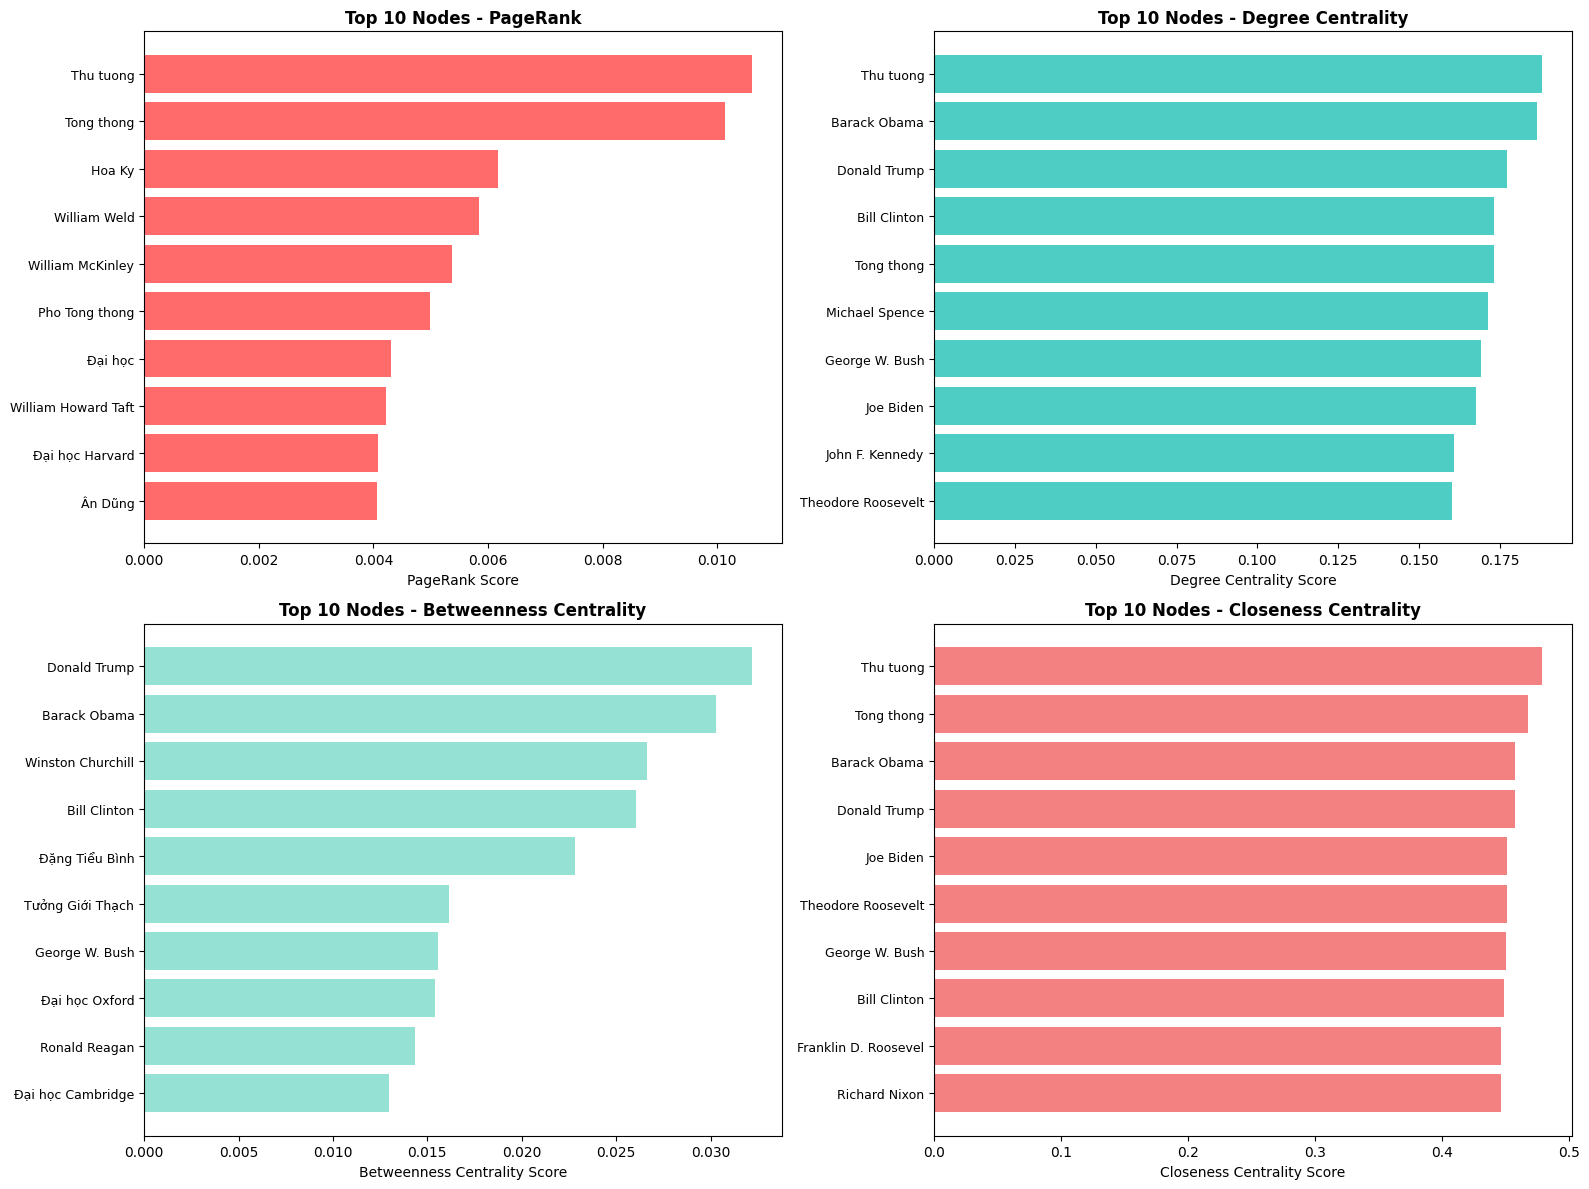

In [38]:
# Hình ảnh hóa xếp hạng
print("\n[Hình ảnh hóa XẾP HẠNG]")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PageRank
pagerank_df = pd.DataFrame(list(top_pagerank), columns=['Node', 'Score'])
pagerank_df['Label'] = pagerank_df['Node'].apply(lambda x: nodes_df[nodes_df['id'] == x]['title'].values[0][:20] if x in nodes_df['id'].values else x)
axes[0, 0].barh(range(len(pagerank_df)), pagerank_df['Score'], color='#FF6B6B')
axes[0, 0].set_yticks(range(len(pagerank_df)))
axes[0, 0].set_yticklabels(pagerank_df['Label'], fontsize=9)
axes[0, 0].set_xlabel('PageRank Score', fontsize=10)
axes[0, 0].set_title('Top 10 Nodes - PageRank', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()

# Degree Centrality
degree_df = pd.DataFrame(list(top_degree), columns=['Node', 'Score'])
degree_df['Label'] = degree_df['Node'].apply(lambda x: nodes_df[nodes_df['id'] == x]['title'].values[0][:20] if x in nodes_df['id'].values else x)
axes[0, 1].barh(range(len(degree_df)), degree_df['Score'], color='#4ECDC4')
axes[0, 1].set_yticks(range(len(degree_df)))
axes[0, 1].set_yticklabels(degree_df['Label'], fontsize=9)
axes[0, 1].set_xlabel('Degree Centrality Score', fontsize=10)
axes[0, 1].set_title('Top 10 Nodes - Degree Centrality', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()

# Betweenness Centrality
betweenness_df = pd.DataFrame(list(top_betweenness), columns=['Node', 'Score'])
betweenness_df['Label'] = betweenness_df['Node'].apply(lambda x: nodes_df[nodes_df['id'] == x]['title'].values[0][:20] if x in nodes_df['id'].values else x)
axes[1, 0].barh(range(len(betweenness_df)), betweenness_df['Score'], color='#95E1D3')
axes[1, 0].set_yticks(range(len(betweenness_df)))
axes[1, 0].set_yticklabels(betweenness_df['Label'], fontsize=9)
axes[1, 0].set_xlabel('Betweenness Centrality Score', fontsize=10)
axes[1, 0].set_title('Top 10 Nodes - Betweenness Centrality', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()

# Closeness Centrality
closeness_df = pd.DataFrame(list(top_closeness), columns=['Node', 'Score'])
closeness_df['Label'] = closeness_df['Node'].apply(lambda x: nodes_df[nodes_df['id'] == x]['title'].values[0][:20] if x in nodes_df['id'].values else x)
axes[1, 1].barh(range(len(closeness_df)), closeness_df['Score'], color='#F38181')
axes[1, 1].set_yticks(range(len(closeness_df)))
axes[1, 1].set_yticklabels(closeness_df['Label'], fontsize=9)
axes[1, 1].set_xlabel('Closeness Centrality Score', fontsize=10)
axes[1, 1].set_title('Top 10 Nodes - Closeness Centrality', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('graph_out/ranking_algorithms.png', dpi=300, bbox_inches='tight')
print("✓ Lưu: graph_out/ranking_algorithms.png")
plt.show()

## 5️⃣ Phát Hiện Cộng Đồng (Community Detection)

In [39]:
print("\n" + "=" * 80)
print("PHÂN TÍCH VÀ ĐẶT TÊN CÁC CỘNG ĐỒNG CHÍNH")
print("=" * 80)

# Sắp xếp cộng đồng theo kích thước
sorted_communities = sorted(community_stats, key=lambda x: x['size'], reverse=True)

print("\n[TOP 10 CỘNG ĐỒNG LỚN NHẤT - Chi tiết]")

for idx, comm_stat in enumerate(sorted_communities[:10], 1):
    comm_id = comm_stat['community_id']
    size = comm_stat['size']
    percentage = comm_stat['percentage']
    node_types = comm_stat['node_types']
    top_nodes = comm_stat['top_nodes']
    
    print(f"\n{'='*70}")
    print(f"CỘNG ĐỒNG #{comm_id + 1} (Xếp hạng: {idx})")
    print(f"{'='*70}")
    print(f"Kích thước: {size} nodes ({percentage:.1f}% của toàn mạng)")
    print(f"Cấu trúc: {node_types}")
    
    # Phân tích top nodes để đặt tên
    print(f"\nTop 5 nhân vật ảnh hưởng:")
    top_people = []
    for node_id, degree in top_nodes[:5]:
        node_title = nodes_df[nodes_df['id'] == node_id]['title'].values[0] if node_id in nodes_df['id'].values else node_id
        node_type = nodes_df[nodes_df['id'] == node_id]['type'].values[0] if node_id in nodes_df['id'].values else 'unknown'
        print(f"  • {node_title} [{node_type}] - Degree: {degree}")
        if node_type == 'person':
            top_people.append(node_title)
    
    # Đặt tên cộng đồng
    if size > 500:
        community_name = "🌍 Cộng đồng Alumni Toàn Cầu (Global Network)"
        description = "Cộng đồng lớn nhất, bao gồm các nhà lãnh đạo chính trị, học giả từ các trường danh tiếng thế giới"
    elif 'university' in node_types and node_types['university'] > node_types.get('person', 0) * 0.3:
        # Nhiều đại học → Academic network
        community_name = "🎓 Cộng đồng Học Thuật (Academic Network)"
        description = f"Tập trung vào các trường đại học và alumni của họ"
    elif len(top_people) > 0 and any(name in ['Barack Obama', 'Donald Trump', 'Bill Clinton', 'George W. Bush'] for name in top_people):
        community_name = "🏛️ Cộng đồng Chính Trị Mỹ (US Political Network)"
        description = "Các chính trị gia, tổng thống và quan chức chính phủ Hoa Kỳ"
    elif len(top_people) > 0 and any('Winston' in name or 'Churchill' in name for name in top_people):
        community_name = "🇬🇧 Cộng đồng Anh - Châu Âu (British-European Network)"
        description = "Các nhà lãnh đạo và học giả từ Anh và châu Âu"
    elif node_types.get('country', 0) > 10:
        community_name = "🌏 Cộng đồng Quốc Tế (International Network)"
        description = "Kết nối đa quốc gia với nhiều khu vực địa lý"
    else:
        community_name = f"🔗 Cộng đồng #{comm_id + 1}"
        description = "Nhóm nhỏ với kết nối đặc thù"
    
    print(f"\n📌 TÊN CỘNG ĐỒNG: {community_name}")
    print(f"📝 MÔ TẢ: {description}")


PHÂN TÍCH VÀ ĐẶT TÊN CÁC CỘNG ĐỒNG CHÍNH

[TOP 10 CỘNG ĐỒNG LỚN NHẤT - Chi tiết]

CỘNG ĐỒNG #1 (Xếp hạng: 1)
Kích thước: 711 nodes (32.9% của toàn mạng)
Cấu trúc: {'person': 412, 'university': 299}

Top 5 nhân vật ảnh hưởng:
  • Christopher Hitchens [person] - Degree: 101
  • Evelyn Waugh [person] - Degree: 96
  • John Turner [person] - Degree: 96

📌 TÊN CỘNG ĐỒNG: 🌍 Cộng đồng Alumni Toàn Cầu (Global Network)
📝 MÔ TẢ: Cộng đồng lớn nhất, bao gồm các nhà lãnh đạo chính trị, học giả từ các trường danh tiếng thế giới

CỘNG ĐỒNG #2 (Xếp hạng: 2)
Kích thước: 678 nodes (31.4% của toàn mạng)
Cấu trúc: {'person': 417, 'university': 261}

Top 5 nhân vật ảnh hưởng:
  • Barack Obama [person] - Degree: 173
  • Đại học Harvard [university] - Degree: 149
  • George W. Bush [person] - Degree: 148

📌 TÊN CỘNG ĐỒNG: 🌍 Cộng đồng Alumni Toàn Cầu (Global Network)
📝 MÔ TẢ: Cộng đồng lớn nhất, bao gồm các nhà lãnh đạo chính trị, học giả từ các trường danh tiếng thế giới

CỘNG ĐỒNG #3 (Xếp hạng: 3)
Kích thư

### 🏘️ Đặt Tên Và Phân Loại Các Cộng Đồng

Mỗi cộng đồng được đặt tên dựa trên:
- **Top nodes** trong cộng đồng (người có degree cao nhất)
- **Loại node chủ đạo** (person, university, country)
- **Đặc điểm chung** (khu vực địa lý, lĩnh vực)

In [40]:
print("\n" + "=" * 80)
print("PHÁT HIỆN CỘNG ĐỒNG (COMMUNITY DETECTION)")
print("=" * 80)

# Sử dụng Louvain method (greedy modularity optimization)
print("\n[Louvain Method - Greedy Modularity Optimization]")
print("  → Phát hiện cộng đồng từ mạng...")

from networkx.algorithms import community

# Louvain (greedy modularity optimization)
communities_louvain = list(community.greedy_modularity_communities(G_undirected))
modularity_louvain = community.modularity(G_undirected, communities_louvain)

print(f"✓ Số cộng đồng phát hiện: {len(communities_louvain)}")
print(f"✓ Modularity Score: {modularity_louvain:.6f}")

# Phân tích cộng đồng
print("\n[Phân tích chi tiết cộng đồng]")
community_stats = []

for idx, comm in enumerate(communities_louvain):
    comm_nodes = list(comm)
    comm_size = len(comm)
    
    # Loại nodes trong cộng đồng
    node_types_in_comm = defaultdict(int)
    for node_id in comm_nodes:
        node_type = nodes_df[nodes_df['id'] == node_id]['type'].values[0] if node_id in nodes_df['id'].values else 'unknown'
        node_types_in_comm[node_type] += 1
    
    # Lấy top nodes theo degree
    subgraph = G_undirected.subgraph(comm_nodes)
    top_nodes_in_comm = sorted(subgraph.degree(), key=lambda x: x[1], reverse=True)[:3]
    
    community_stats.append({
        'community_id': idx,
        'size': comm_size,
        'percentage': (comm_size / G_undirected.number_of_nodes() * 100),
        'node_types': dict(node_types_in_comm),
        'top_nodes': top_nodes_in_comm
    })
    
    print(f"\nCộng đồng {idx + 1}:")
    print(f"  • Kích thước: {comm_size} nodes ({comm_size/G_undirected.number_of_nodes()*100:.2f}%)")
    print(f"  • Loại nodes: {dict(node_types_in_comm)}")
    print(f"  • Top 3 nodes:")
    for node_id, degree in top_nodes_in_comm[:3]:
        node_title = nodes_df[nodes_df['id'] == node_id]['title'].values[0] if node_id in nodes_df['id'].values else node_id
        node_type = nodes_df[nodes_df['id'] == node_id]['type'].values[0] if node_id in nodes_df['id'].values else 'unknown'
        print(f"      - {node_title} [{node_type}] (Degree: {degree})")

# Thống kê cộng đồng
print(f"\n[THỐNG KÊ CỘNG ĐỒNG]")
print(f"Kích thước cộng đồng:")
sizes = [stat['size'] for stat in community_stats]
print(f"  • Lớn nhất: {max(sizes)}")
print(f"  • Nhỏ nhất: {min(sizes)}")
print(f"  • Trung bình: {np.mean(sizes):.1f}")
print(f"  • Trung vị: {np.median(sizes):.1f}")


PHÁT HIỆN CỘNG ĐỒNG (COMMUNITY DETECTION)

[Louvain Method - Greedy Modularity Optimization]
  → Phát hiện cộng đồng từ mạng...
✓ Số cộng đồng phát hiện: 23
✓ Modularity Score: 0.381041

[Phân tích chi tiết cộng đồng]
✓ Số cộng đồng phát hiện: 23
✓ Modularity Score: 0.381041

[Phân tích chi tiết cộng đồng]

Cộng đồng 1:
  • Kích thước: 844 nodes (38.86%)
  • Loại nodes: {'person': 464, 'university': 336, 'country': 27, 'career': 17}
  • Top 3 nodes:
      - Tong thong [career] (Degree: 160)
      - Christopher Hitchens [person] (Degree: 115)
      - Winston Churchill [person] (Degree: 108)

Cộng đồng 1:
  • Kích thước: 844 nodes (38.86%)
  • Loại nodes: {'person': 464, 'university': 336, 'country': 27, 'career': 17}
  • Top 3 nodes:
      - Tong thong [career] (Degree: 160)
      - Christopher Hitchens [person] (Degree: 115)
      - Winston Churchill [person] (Degree: 108)

Cộng đồng 2:
  • Kích thước: 646 nodes (29.74%)
  • Loại nodes: {'person': 373, 'university': 237, 'country': 25


[Hình ảnh hóa CỘNG ĐỒNG]
✓ Lưu: graph_out/community_detection.png
✓ Lưu: graph_out/community_detection.png


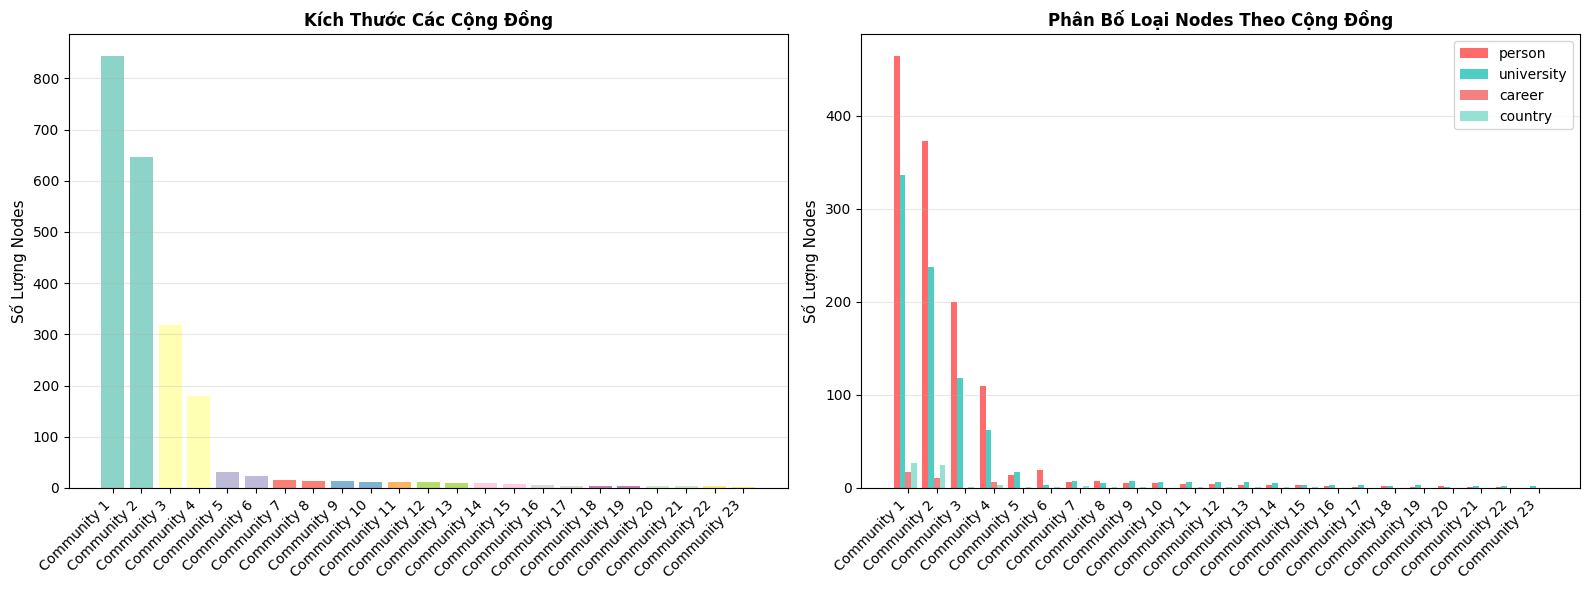

In [41]:
# Hình ảnh hóa cộng đồng
print("\n[Hình ảnh hóa CỘNG ĐỒNG]")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ kích thước cộng đồng
comm_sizes = [stat['size'] for stat in community_stats]
comm_labels = [f"Community {i+1}" for i in range(len(community_stats))]
colors_comm = plt.cm.Set3(np.linspace(0, 1, len(comm_sizes)))

axes[0].bar(range(len(comm_sizes)), comm_sizes, color=colors_comm)
axes[0].set_xticks(range(len(comm_sizes)))
axes[0].set_xticklabels(comm_labels, rotation=45, ha='right')
axes[0].set_ylabel('Số Lượng Nodes', fontsize=11)
axes[0].set_title('Kích Thước Các Cộng Đồng', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Phân bố loại nodes trong mỗi cộng đồng
node_type_distribution = {}
for node_type in nodes_df['type'].unique():
    node_type_distribution[node_type] = [stat['node_types'].get(node_type, 0) for stat in community_stats]

x = np.arange(len(comm_labels))
width = 0.2
colors_types = {'person': '#FF6B6B', 'university': '#4ECDC4', 'country': '#95E1D3', 'career': '#F38181'}

for i, (node_type, values) in enumerate(node_type_distribution.items()):
    offset = (i - len(node_type_distribution) / 2) * width
    axes[1].bar(x + offset, values, width, label=node_type, color=colors_types.get(node_type, '#999999'))

axes[1].set_xticks(x)
axes[1].set_xticklabels(comm_labels, rotation=45, ha='right')
axes[1].set_ylabel('Số Lượng Nodes', fontsize=11)
axes[1].set_title('Phân Bố Loại Nodes Theo Cộng Đồng', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('graph_out/community_detection.png', dpi=300, bbox_inches='tight')
print("✓ Lưu: graph_out/community_detection.png")
plt.show()

## 6️⃣ Tóm Tắt & Kết Luận

In [42]:
print("\n" + "=" * 80)
print("TÓM TẮT & KẾT LUẬN - PHÂN TÍCH MẠNG XÃ HỘI ALUMNI")
print("=" * 80)

print("\n[1. KHÁI NIỆM THẾ GIỚI NHỎ (SMALL WORLD)]")
print(f"  ✓ Khoảng cách ngắn nhất trung bình: {avg_path_length:.4f} hops")
if diameter:
    print(f"  ✓ Đường kính mạng: {diameter}")
print(f"  ✓ Hệ số gom cụm: {avg_clustering:.6f}")
print(f"  ✓ Small World Coefficient (σ): {sigma:.4f}")

if sigma > 1:
    print(f"\n  ➜ KẾT LUẬN: Mạng Alumni có tính chất THẾ GIỚI NHỎ")
    print(f"     - Người dùng cách nhau rất gần (avg path ≈ {avg_path_length:.2f})")
    print(f"     - Nhưng có độ gom cụm cao (clustering ≈ {avg_clustering:.4f})")
    print(f"     - Điều này cho thấy sự tồn tại của các \"nhóm bạn\" chặt chẽ")
else:
    print(f"\n  ➜ KẾT LUẬN: Mạng có tính chất không hoàn toàn Small World")

print("\n[2. THUẬT TOÁN XẾP HẠNG (RANKING ALGORITHMS)]")
print(f"  ✓ PageRank: Xác định các node có ảnh hưởng cao")
print(f"  ✓ Degree Centrality: Xác định các hub trực tiếp kết nối")
print(f"  ✓ Betweenness Centrality: Xác định những người \"cầu nối\"")
print(f"  ✓ Closeness Centrality: Xác định những người \"trung tâm\"")
print(f"\n  ➜ Top node theo PageRank:")

if top_pagerank:
    top_node = top_pagerank[0]
    top_title = nodes_df[nodes_df['id'] == top_node[0]]['title'].values[0] if top_node[0] in nodes_df['id'].values else top_node[0]
    top_type = nodes_df[nodes_df['id'] == top_node[0]]['type'].values[0] if top_node[0] in nodes_df['id'].values else 'unknown'
    print(f"     - {top_title} [{top_type}] (Score: {top_node[1]:.6f})")

print("\n[3. PHÁT HIỆN CỘNG ĐỒNG (COMMUNITY DETECTION)]")
print(f"  ✓ Số cộng đồng phát hiện: {len(communities_louvain)}")
print(f"  ✓ Modularity Score: {modularity_louvain:.6f}")
print(f"  ✓ Kích thước cộng đồng từ {min(sizes)} đến {max(sizes)} nodes")

print(f"\n  ➜ Ý NGHĨA:")
print(f"     - Mạng Alumni tự tổ chức thành {len(communities_louvain)} cộng đồng")
print(f"     - Mỗi cộng đồng đại diện một \"nhánh\" của mạng với kết nối chặt chẽ")
if modularity_louvain > 0.3:
    print(f"     - Modularity cao ({modularity_louvain:.4f}) → Cộng đồng rõ ràng, tách biệt")
elif modularity_louvain > 0.1:
    print(f"     - Modularity trung bình ({modularity_louvain:.4f}) → Cộng đồng yếu, nhiều liên kết xuyên")
else:
    print(f"     - Modularity thấp ({modularity_louvain:.4f}) → Mạng liên thông tốt, ít tách biệt")

print("\n" + "=" * 80)
print("✓ PHÂN TÍCH HOÀN TẤT")
print("=" * 80)


TÓM TẮT & KẾT LUẬN - PHÂN TÍCH MẠNG XÃ HỘI ALUMNI

[1. KHÁI NIỆM THẾ GIỚI NHỎ (SMALL WORLD)]
  ✓ Khoảng cách ngắn nhất trung bình: 3.1381 hops
  ✓ Đường kính mạng: 7
  ✓ Hệ số gom cụm: 0.470704
  ✓ Small World Coefficient (σ): 13.0079

  ➜ KẾT LUẬN: Mạng Alumni có tính chất THẾ GIỚI NHỎ
     - Người dùng cách nhau rất gần (avg path ≈ 3.14)
     - Nhưng có độ gom cụm cao (clustering ≈ 0.4707)
     - Điều này cho thấy sự tồn tại của các "nhóm bạn" chặt chẽ

[2. THUẬT TOÁN XẾP HẠNG (RANKING ALGORITHMS)]
  ✓ PageRank: Xác định các node có ảnh hưởng cao
  ✓ Degree Centrality: Xác định các hub trực tiếp kết nối
  ✓ Betweenness Centrality: Xác định những người "cầu nối"
  ✓ Closeness Centrality: Xác định những người "trung tâm"

  ➜ Top node theo PageRank:
     - Thu tuong [career] (Score: 0.010604)

[3. PHÁT HIỆN CỘNG ĐỒNG (COMMUNITY DETECTION)]
  ✓ Số cộng đồng phát hiện: 23
  ✓ Modularity Score: 0.381041
  ✓ Kích thước cộng đồng từ 2 đến 844 nodes

  ➜ Ý NGHĨA:
     - Mạng Alumni tự tổ ch